In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyaugsynth import Dataprep, Synth

In [2]:
df = pd.read_csv('texas.csv')

dataprep = Dataprep(
    foo=df,
    predictors=('bmprison', 'income', 'ur', 'poverty'),
    predictors_op='mean',
    time_predictors_prior=range(1985, 2001),
    special_predictors=(
        ('bmprison', [1988] ,'mean'),
        ('bmprison', [1990], 'mean'),
        ('bmprison', [1991], 'mean'),
        ('bmprison', [1992], 'mean'),
        ('alcohol', [1990], 'mean'),
        ('aidscapita', [1990], 'mean'),
        ('aidscapita', [1991], 'mean'),
        ('black', [1990], 'mean'),
        ('black', [1991], 'mean'),
        ('black', [1992], 'mean'),
        ('perc1519', [1990], 'mean')
    ),
    dependent='bmprison',
    unit_variable='state',
    time_variable='year',
    treatment_identifier='Texas',
    controls_identifier=('Alabama', 'Alaska', 'Arizona', 'Arkansas',
        'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
        'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
        'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
        'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
        'New York', 'North Carolina', 'North Dakota', 'Ohio',
        'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
        'South Carolina', 'South Dakota', 'Tennessee', 'Utah',
        'Vermont', 'Virginia', 'Washington', 'West Virginia',
        'Wisconsin', 'Wyoming'),
    time_optimize_ssr=range(1985, 1994)
)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method='BFGS', optim_initial='ols')

In [3]:
print("Non-zero weights:")
for region, weight in zip(dataprep.controls_identifier, synth.W):
    if weight > 1e-5:
        print("  ", region, round(weight, 3))

Non-zero weights:
   California 0.394
   Florida 0.095
   Illinois 0.394
   Louisiana 0.117


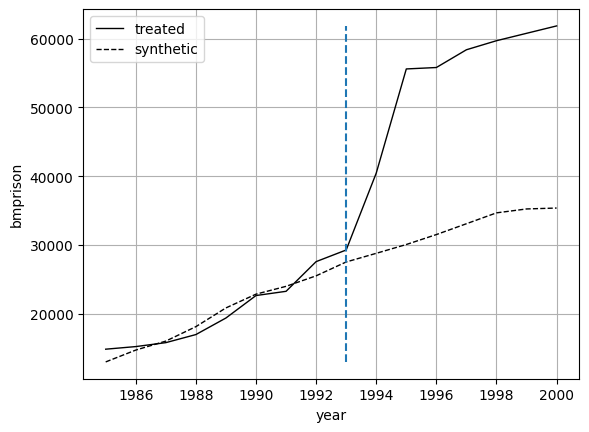

In [4]:
synth.path_plot(treatment_time=1993)

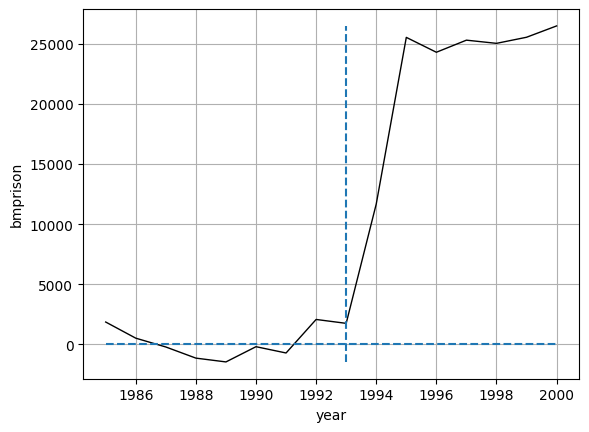

In [5]:
synth.gaps_plot(treatment_time=1993)